In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)

In [2]:
# Dataset class
class SARImageDataset(Dataset):
    def __init__(self, data, root_dir, transform=None, mode='train'):
        self.df = data
        self.root_dir = root_dir
        self.transform = transform
        self.mode = mode

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.df.iloc[idx]["id"]) + ".png")
        image = Image.open(img_name).convert("RGB")
        if self.transform:
            image = self.transform(image)

        if self.mode in ['train', 'val']:
            label = self.df.iloc[idx]["ground_truth"]
            return image, label
        else:
            return image, self.df.iloc[idx]["id"]

    def __len__(self):
        return len(self.df)



In [3]:
# Paths and data loading
train_csv_path = "train.csv"
test_csv_path = "test.csv"
solutions_csv_path = "solution.csv"
train_images_path = "images_train"
test_images_path = "images_test"

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
solutions_df = pd.read_csv(solutions_csv_path)

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [4]:
# Datasets and DataLoaders
train_dataset = SARImageDataset(train_df, train_images_path, transform=transform, mode='train')
test_dataset = SARImageDataset(test_df, test_images_path, transform=transform, mode='test')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


In [5]:
# Define MLP Model
class MLPModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, 256)
        self.bn3 = nn.BatchNorm1d(256)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(256, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [6]:
# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPModel(input_size=224 * 224 * 3, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [7]:
# Training
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    all_labels = []
    all_preds = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_loss / len(train_loader):.4f}, "
          f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")

    scheduler.step()


Epoch 1/20, Loss: 0.7309, Accuracy: 0.55, Precision: 0.55, Recall: 0.55, F1-Score: 0.55
Epoch 2/20, Loss: 0.6828, Accuracy: 0.58, Precision: 0.58, Recall: 0.58, F1-Score: 0.58
Epoch 3/20, Loss: 0.6664, Accuracy: 0.60, Precision: 0.60, Recall: 0.60, F1-Score: 0.60
Epoch 4/20, Loss: 0.6739, Accuracy: 0.60, Precision: 0.60, Recall: 0.59, F1-Score: 0.59
Epoch 5/20, Loss: 0.6621, Accuracy: 0.61, Precision: 0.61, Recall: 0.61, F1-Score: 0.61
Epoch 6/20, Loss: 0.6604, Accuracy: 0.61, Precision: 0.62, Recall: 0.61, F1-Score: 0.61
Epoch 7/20, Loss: 0.6503, Accuracy: 0.61, Precision: 0.61, Recall: 0.61, F1-Score: 0.61
Epoch 8/20, Loss: 0.6535, Accuracy: 0.61, Precision: 0.61, Recall: 0.61, F1-Score: 0.61
Epoch 9/20, Loss: 0.6493, Accuracy: 0.62, Precision: 0.62, Recall: 0.62, F1-Score: 0.62
Epoch 10/20, Loss: 0.6485, Accuracy: 0.62, Precision: 0.63, Recall: 0.62, F1-Score: 0.62
Epoch 11/20, Loss: 0.6504, Accuracy: 0.62, Precision: 0.62, Recall: 0.62, F1-Score: 0.62
Epoch 12/20, Loss: 0.6480, Acc

In [8]:
# Inference on Test Data
model.eval()
predictions = []
image_ids = []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        predictions.extend(preds.cpu().numpy())
        image_ids.extend(ids)

predictions_df = pd.DataFrame({"id": image_ids, "prediction": predictions})


In [9]:
# Merge with Ground Truth for Evaluation
solutions_df["id"] = solutions_df["id"].astype(str)
predictions_df["id"] = predictions_df["id"].astype(str)

merged_df = pd.merge(predictions_df, solutions_df, on="id")
y_true = merged_df["ground_truth"]
y_pred = merged_df["prediction"]


In [10]:
# Metrics
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="macro"))
print("Recall:", recall_score(y_true, y_pred, average="macro"))
print("F1-Score:", f1_score(y_true, y_pred, average="macro"))

Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.48      0.55       719
           1       0.59      0.74      0.66       740

    accuracy                           0.61      1459
   macro avg       0.62      0.61      0.60      1459
weighted avg       0.62      0.61      0.60      1459

Accuracy: 0.6106922549691569
Precision: 0.6164644100782488
Recall: 0.6088749389166636
F1-Score: 0.6034627958075902


Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.46      0.55       719
           1       0.60      0.78      0.68       740

    accuracy                           0.63      1459
   macro avg       0.64      0.62      0.61      1459
weighted avg       0.64      0.63      0.62      1459

Accuracy: 0.6257710760795065
Precision: 0.6379352340636404
Recall: 0.6234635191519753
F1-Score: 0.6147290285886737


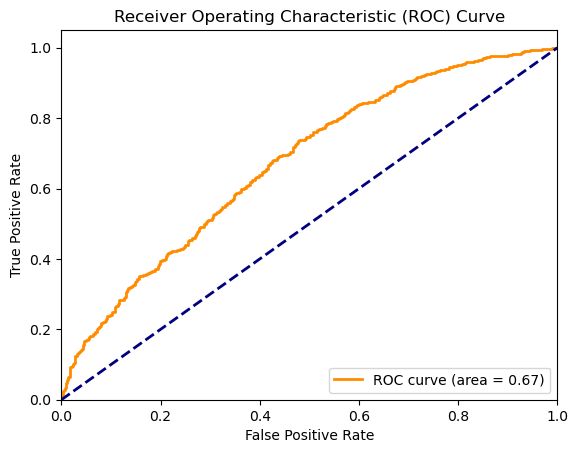

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Inference on Test Data
model.eval()
predictions = []
image_ids = []
probs = []

with torch.no_grad():
    for images, ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]  # Get probabilities for the positive class

        predictions.extend(preds.cpu().numpy())
        image_ids.extend(ids)
        probs.extend(probabilities.cpu().numpy())

predictions_df = pd.DataFrame({"id": image_ids, "prediction": predictions, "probability": probs})

# Merge with Ground Truth for Evaluation
solutions_df["id"] = solutions_df["id"].astype(str)
predictions_df["id"] = predictions_df["id"].astype(str)

merged_df = pd.merge(predictions_df, solutions_df, on="id")
y_true = merged_df["ground_truth"]
y_pred = merged_df["prediction"]
y_prob = merged_df["probability"]

# Metrics
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average="macro"))
print("Recall:", recall_score(y_true, y_pred, average="macro"))
print("F1-Score:", f1_score(y_true, y_pred, average="macro"))

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = roc_auc_score(y_true, y_prob)

# Plot AUC-ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
